<h1>Imports<h1>

In [1]:
#setting rood directory into ../NeuralPowerDisaggregation
import os
os.chdir("..")
print(os.getcwd())

/work/lurny/files/Thesis


In [2]:
config = {
    'gdt': {
        'depth': 10,
                
        'learning_rate_index': 0.05,
        'learning_rate_values': 0.01,
        'learning_rate_leaf': 0.005,
        
        'dropout': 0, #0.2 oder 0.5
        
        
        'initializer_values': 'GlorotUniform', 
        'initializer_index': 'GlorotUniform', 
        'initializer_leaf': 'GlorotUniform', 
        
        'optimizer': 'adam', 
        
        'batch_size': 500,#120
        'epochs': 1,
        
        'restarts': 0,#
        'restart_type': 'loss', #'loss', 'metric'
        
        'early_stopping_epochs': 600,
        'early_stopping_type': 'loss', #'loss', 'metric'
        'early_stopping_epsilon': 0.0,
        
        'pretrain_epochs': 10,
    },
    
    'preprocessing': {
        'balance_threshold': 0.8,#.25, #if minclass fraction less than threshold/num_classes | #0=no rebalance, 1=rebalance all
        'normalization_technique': 'mean', #'min-max'
    },

    'computation': {
        'random_seed': 42,
        'trials': 10, # fixed to 1 for HPO
        
        'use_best_hpo_result': True,
        'force_depth': False,
        
        'use_gpu': True,
        'gpu_numbers': '3',#'1',
        'n_jobs': 10, #vorher 20
        'verbosity': 0,
        
        
        'hpo': None,#'binary', #'binary', 'multi', 'regression'
        'search_iterations': 300,
        'cv_num': 3,     
        
        'metrics_class': ['f1', 'roc_auc', 'accuracy'],
        
        'metrics_reg': ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error', 'neg_mean_squared_error'],
        
        'eval_metric_class': ['f1', 'roc_auc'], #f1 accuracy
        'eval_metric_reg': 'r2', #r2 mae        
        
        'max_total_samples': 1000000,
        'chunk_size': 1000,#default 200
        'pretrain_size': 1000,
    },
    
    'benchmarks': {
        #'sklearn': True,
        #'GeneticTree': True,        
    }
}

In [3]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
#from pydl85 import DL85Classifier

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

if config['computation']['use_gpu']:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(config['computation']['gpu_numbers'])
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-11.6"
    os.environ['TF_XLA_FLAGS'] = "--tf_xla_enable_xla_devices --tf_xla_auto_jit=2"    
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false' 
#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities_GDT import *
from utilities.GDT_for_streams import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy
from pathlib import Path
import pickle
import dill

from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses
import time

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

from datetime import datetime
timestr = datetime.utcnow().strftime('%Y-%m-%d--%H-%M-%S%f')
print(timestr)
os.makedirs(os.path.dirname("./evaluation_results/latex_tables/" + timestr +"/"), exist_ok=True)

filepath = './evaluation_results/depth' + str(config['gdt']['depth']) + '/' + timestr + '/'
Path(filepath).mkdir(parents=True, exist_ok=True)    


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

2023-01-09--12-43-10354834


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


In [5]:
import math
def split_df_chunks(data_df,chunk_size):
    total_length     = len(data_df)
    normal_chunk_num = math.floor(total_length/chunk_size)
    chunks = []
    for i in range(normal_chunk_num):
        chunk = data_df[(i*chunk_size):((i+1)*chunk_size)]
        chunks.append(chunk)

    return chunks

# Evaluation of agr_a dataset

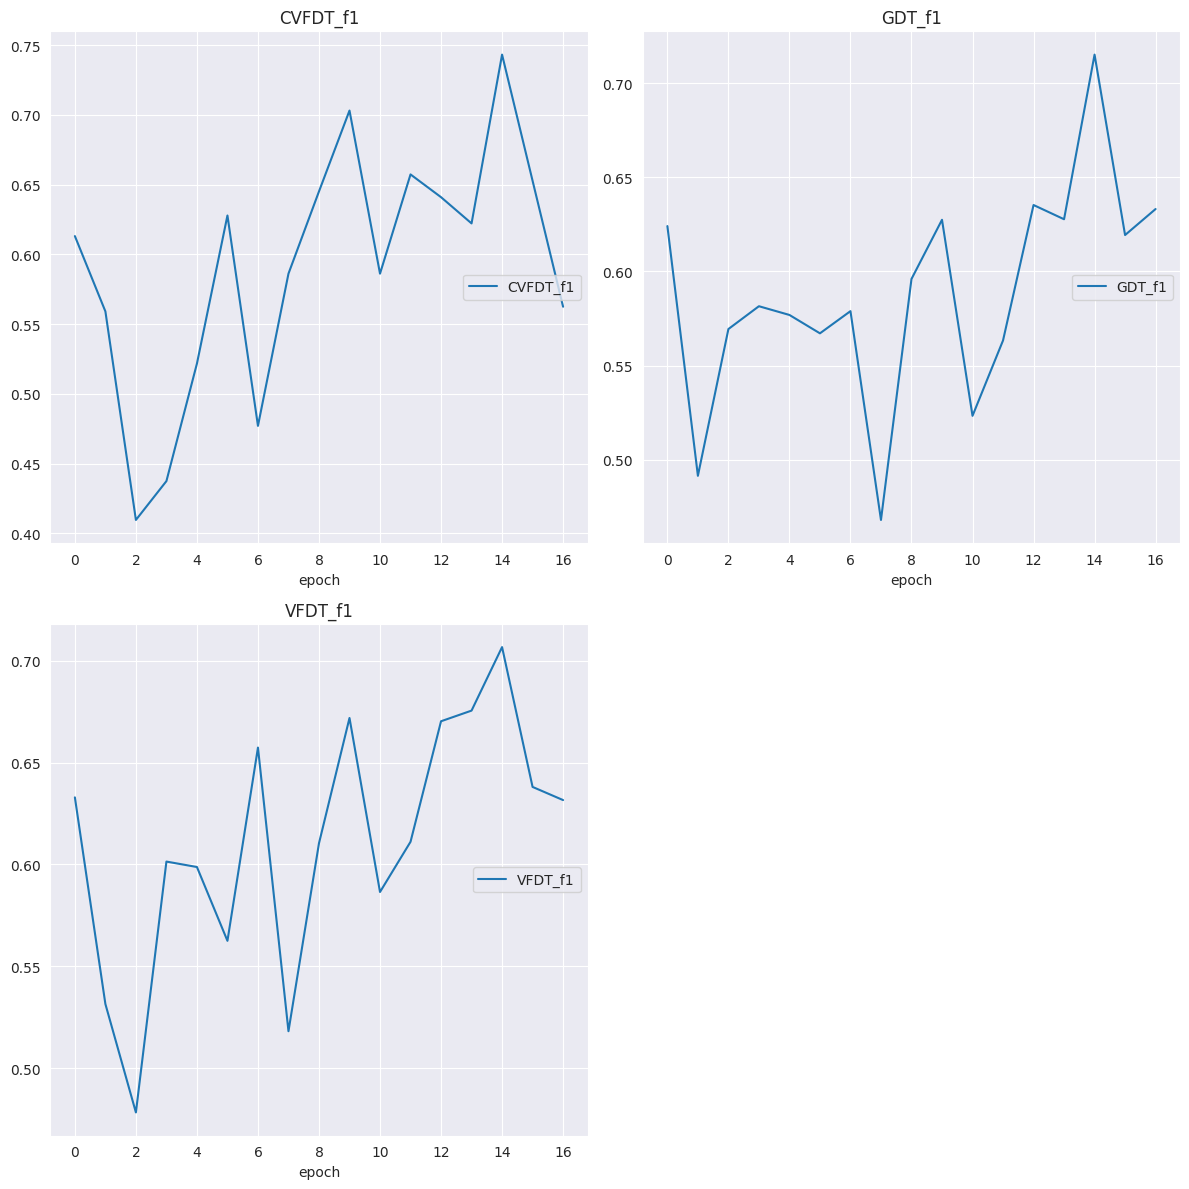

CVFDT_f1
	CVFDT_f1         	 (min:    0.410, max:    0.743, cur:    0.562)
GDT_f1
	GDT_f1           	 (min:    0.468, max:    0.715, cur:    0.633)
VFDT_f1
	VFDT_f1          	 (min:    0.478, max:    0.707, cur:    0.632)


In [8]:
VFDT_classifier = HoeffdingTreeClassifier()
CVFDT_classifier = HoeffdingAdaptiveTreeClassifier(split_confidence = 0.001)
dataset_name = 'NOAA_Weather'

config_training, metrics = prepare_training_for_streams(identifier = 'BIN:'+dataset_name, config = config)
#load Dataset
X_data, y_data, nominal_features, ordinal_features = load_dataset_for_streams(identifier = 'BIN:'+dataset_name, 
                                                                              max_total_samples = config['computation']['max_total_samples'])

model_dict = {}
scores_dict = {}
normalizer_list = []
plotlosses_benchmark = PlotLosses()
verbosity = 1
model_dict['GDT'] = GDT(number_of_variables = len(X_data.columns),
            number_of_classes = len(np.unique(y_data)),#dataset_dict['number_of_classes'],

            objective = config_training['gdt']['objective'],

            depth = config_training['gdt']['depth'],

            learning_rate_index = config_training['gdt']['learning_rate_index'],
            learning_rate_values = config_training['gdt']['learning_rate_values'],
            learning_rate_leaf = config_training['gdt']['learning_rate_leaf'],

            optimizer = config_training['gdt']['optimizer'],

            loss = 'crossentropy',

            initializer_values = config_training['gdt']['initializer_values'],
            initializer_index = config_training['gdt']['initializer_index'],
            initializer_leaf = config_training['gdt']['initializer_leaf'],        

            random_seed = config_training['computation']['random_seed'],
            verbosity = verbosity)  


#Pretraing
if(config_training['computation']['pretrain_size']>0 and len(X_data) > config_training['computation']['pretrain_size']):
    X_pretrain_data = X_data.iloc[:config_training['computation']['pretrain_size'],:]
    X_data = X_data.iloc[config_training['computation']['pretrain_size']:,:]
    y_pretrain_data = y_data.iloc[:config_training['computation']['pretrain_size']]
    y_data = y_data.iloc[config_training['computation']['pretrain_size']:]
    
    ((X_train, y_train),
     (X_valid, y_valid),
     (X_test, y_test),
     (X_train_with_valid, y_train_with_valid),
     normalizer_list) = preprocess_data(X_pretrain_data, 
                                       y_pretrain_data,
                                       nominal_features,
                                       ordinal_features,
                                       config_training,
                                       normalizer_list,
                                       random_seed= 42,#random_seed,
                                       verbosity=1)#verbosity)  
    dataset_dict = {
           'X_train': X_train,
           'y_train': y_train,
           'X_valid': X_valid,
           'y_valid': y_valid,
           'X_test': X_test,
           'y_test': y_test,
           'normalizer_list': normalizer_list
           }
    
    
    
    model_dict['GDT'].partial_fit(dataset_dict['X_train'],
              dataset_dict['y_train'],

              batch_size=config_training['gdt']['batch_size'], 
              epochs=config_training['gdt']['pretrain_epochs'], 

              restarts = 0,#config_test['gdt']['restarts'], 
              #restart_type=config_test['gdt']['restart_type'], 

              #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
              #early_stopping_type=config_test['gdt']['early_stopping_type'],

              valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))
    
    #pretrain benchmarks
    #(X_train_with_valid, y_train_with_valid)
    temp_X_train =X_train_with_valid.values
    temp_y_train =y_train_with_valid.values
    for i in range(0, len(dataset_dict['X_train'])):
        VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64)) 
        CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
    





#Start Stream
X_data_stream = split_df_chunks(X_data, config['computation']['chunk_size'])
y_data_stream = split_df_chunks(y_data, config['computation']['chunk_size'])

scores_GDT = {'f1':np.array([]),
              'acc':np.array([])
             }
scores_VFDT = {'f1':np.array([]),
              'acc':np.array([])
             }
scores_CVFDT = {'f1':np.array([]),
              'acc':np.array([])
             }
timer = {'training':{
            'GDT':0.0,
            'VFDT':0.0,
            'CVFDT':0.0,
         },
         'prediction':{
            'GDT':0.0,
            'VFDT':0.0,
            'CVFDT':0.0,
         }
        }
flag = False;

for i in range(len(X_data_stream)):
    normalizer_list=[]
    t0 = time.time()
    ((X_train, y_train),
     (X_valid, y_valid),
     (X_test, y_test),
     (X_train_with_valid, y_train_with_valid),
     normalizer_list) = preprocess_data(X_data_stream[i], 
                                       y_data_stream[i],
                                       nominal_features,
                                       ordinal_features,
                                       config_training,
                                       normalizer_list,
                                       random_seed= 42,#random_seed,
                                       verbosity=1)#verbosity)  
    dataset_dict = {
           'X_train': X_train,
           'y_train': y_train,
           'X_valid': X_valid,
           'y_valid': y_valid,
           'X_test': X_test,
           'y_test': y_test,
           'normalizer_list': normalizer_list
           } 
    
    t1 = time.time()

    t0 = time.time()
    if(i==13):
        flag = True
    if(i==30):
        break
    history = model_dict['GDT'].partial_fit(dataset_dict['X_train'],
              dataset_dict['y_train'],

              batch_size=config_training['gdt']['batch_size'], 
              epochs=config_training['gdt']['epochs'], 

              restarts = 0,
              drift_flag = flag,
              #config_test['gdt']['restarts'], 
              #restart_type=config_test['gdt']['restart_type'], 

              #early_stopping_epochs=config_training['gdt']['early_stopping_epochs'], 
              #early_stopping_type=config_test['gdt']['early_stopping_type'],

              valid_data=(dataset_dict['X_valid'],dataset_dict['y_valid']))
    
    flag=False
    t1 = time.time()
    timer['training']['GDT'] = timer['training']['GDT']+t1-t0

    
    ###EVALUATION
    y_test_data =dataset_dict['y_test'].values
    temp_X_test = dataset_dict['X_test'].values
    
    temp_X_train =X_train_with_valid.values
    temp_y_train =y_train_with_valid.values
    
    
    t0 = time.time()
    #GDT
    metric = "f1"
    y_test_data = dataset_dict['y_test']
    y_pred_GDT = model_dict['GDT'].predict(enforce_numpy(temp_X_test))
    y_pred_GDT = np.nan_to_num(y_pred_GDT)
    y_pred_GDT = np.round(y_pred_GDT)
    #GDT_f1 = sklearn.metrics.get_scorer(metric)._score_func(y_pred_GDT, y_test, average='weighted')
    GDT_f1 = f1_score(y_test_data, y_pred_GDT)
    GDT_acc = accuracy_score(y_test_data, y_pred_GDT)
       
    t1 = time.time()
    timer['prediction']['GDT'] = timer['prediction']['GDT']+t1-t0
    

    #VFDT
    t0 = time.time()
    y_pred_VFDT = []
    for i in range(0, len(temp_X_train)):
        VFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
    t1 = time.time()
    timer['training']['VFDT'] = timer['training']['VFDT']+t1-t0
    
    t0 = time.time()
    for i in range(0, len(dataset_dict['X_test'])):
        y_pred_VFDT.append(VFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
    VFDT_f1 = f1_score(y_test_data, y_pred_VFDT)
    VFDT_acc = accuracy_score(y_test_data, y_pred_VFDT)
    t1 = time.time()
    timer['prediction']['VFDT'] = timer['prediction']['VFDT']+t1-t0
    
    #CVFDT
    t0 = time.time()
    y_pred_CVFDT = []
    for i in range(0, len(dataset_dict['X_train'])):
        CVFDT_classifier.partial_fit(np.array([temp_X_train[i]], np.float64), np.array([temp_y_train[i]], np.float64))
    t1 = time.time()
    timer['training']['CVFDT'] = timer['training']['CVFDT']+t1-t0
    
    t0 = time.time()
    for i in range(0, len(dataset_dict['X_test'])):
        y_pred_CVFDT.append(CVFDT_classifier.predict(np.array([temp_X_test[i]], np.float64))[0])  
    CVFDT_f1 = f1_score(y_test_data, y_pred_CVFDT)
    CVFDT_acc = accuracy_score(y_test_data, y_pred_CVFDT)
    t1 = time.time()
    timer['prediction']['CVFDT'] = timer['prediction']['CVFDT']+t1-t0

    
    
    plotlosses_benchmark.update({'GDT_f1': GDT_f1,'VFDT_f1': VFDT_f1, 'CVFDT_f1':CVFDT_f1})
    plotlosses_benchmark.send() 
    
    
    scores_GDT['f1'] = np.append(scores_GDT['f1'], GDT_f1)
    scores_VFDT['f1'] = np.append(scores_VFDT['f1'], VFDT_f1)
    scores_CVFDT['f1'] = np.append(scores_CVFDT['f1'], CVFDT_f1)
    scores_GDT['acc'] = np.append(scores_GDT['acc'], GDT_acc)
    scores_VFDT['acc'] = np.append(scores_VFDT['acc'], VFDT_acc)
    scores_CVFDT['acc'] = np.append(scores_CVFDT['acc'], CVFDT_acc)
    
    
     

    #scores_dict['GDT'] = calculate_scores(model_dict = model_dict, 
     #                              dataset_dict = dataset_dict, 
      #                             scores_dict = prepare_score_dict(config=config_training), 
       #                            metrics = metrics)            

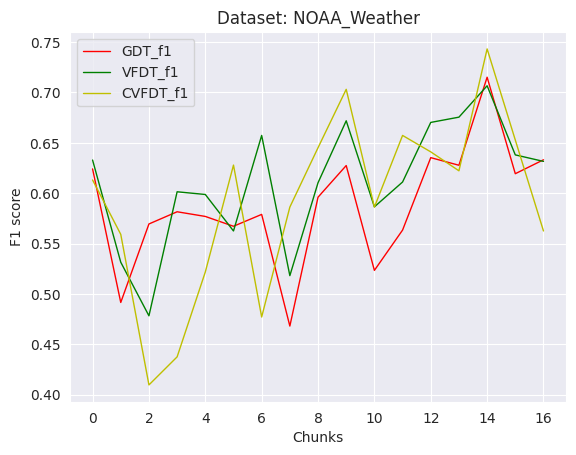

median GDT F1: 0.5816       avg: 0.5882
median VFDT F1: 0.6111       avg: 0.6107
median CVFDT F1: 0.6131       avg: 0.5909


In [9]:
#Plot results
X = np.arange(0, len(scores_GDT['f1']), 1)
  
# Assign variables to the y axis part of the curve
#plt.rc('text', usetex=True)
#plt.rc('font', family = 'Computer Modern')
  
# Plotting both the curves simultaneously
plt.plot(X, scores_GDT['f1'], color='r', label='GDT_f1', linewidth=1)
plt.plot(X, scores_VFDT['f1'], color='g', label='VFDT_f1', linewidth=1)
plt.plot(X, scores_CVFDT['f1'], color='y', label='CVFDT_f1', linewidth=1)

  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Chunks")
plt.ylabel("F1 score")
plt.title("Dataset: " + dataset_name)
plt.legend()
plt.show()

print("median GDT F1: " + str(round(np.median(scores_GDT['f1']),4)) + "       avg: " +str(round(np.average(scores_GDT['f1']),4)))
print("median VFDT F1: " + str(round(np.median(scores_VFDT['f1']),4)) + "       avg: "+ str(round(np.average(scores_VFDT['f1']),4)))
print("median CVFDT F1: " + str(round(np.median(scores_CVFDT['f1']),4)) + "       avg: "+ str(round(np.average(scores_CVFDT['f1']),4)))

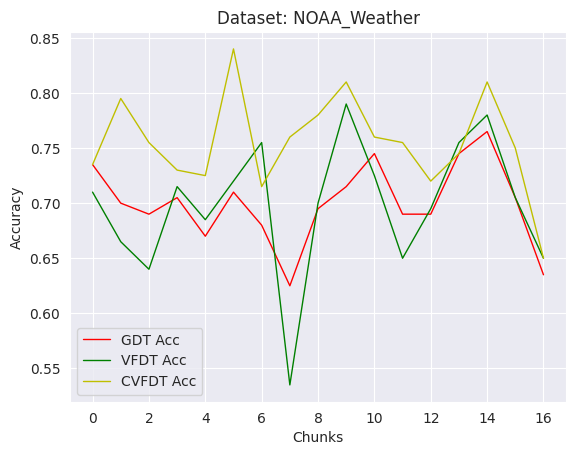

median GDT Accuracy: 0.7
median VFDT Accuracy: 0.705
median CVFDT Accuracy: 0.755


In [10]:
#Plot results
X = np.arange(0, len(scores_GDT['acc']), 1)
  
# Assign variables to the y axis part of the curve
  
# Plotting both the curves simultaneously
plt.plot(X, scores_GDT['acc'], color='r', label='GDT Acc', linewidth=1)
plt.plot(X, scores_VFDT['acc'], color='g', label='VFDT Acc', linewidth=1)
plt.plot(X, scores_CVFDT['acc'], color='y', label='CVFDT Acc', linewidth=1)
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Chunks")
plt.ylabel("Accuracy")
plt.title("Dataset: " + dataset_name)
plt.legend()
plt.show()

print("median GDT Accuracy: " + str(np.median(scores_GDT['acc'])))
print("median VFDT Accuracy: " + str(np.median(scores_VFDT['acc'])))
print("median CVFDT Accuracy: " + str(np.median(scores_CVFDT['acc'])))

In [41]:
#output performance
#Global:(Average, Median)  Sliding:() 
results = pd.DataFrame(columns=['Metric','Operation','GDT','VFDT','CFVDT'])
results.loc[len(results)] = ['f1','median',round(np.median(scores_GDT['f1']),4),round(np.median(scores_VFDT['f1']),4),round(np.median(scores_CVFDT['f1']),4)]
results.loc[len(results)] = ['f1','average',round(np.average(scores_GDT['f1']),4),round(np.average(scores_VFDT['f1']),4),round(np.average(scores_CVFDT['f1']),4)]
results.loc[len(results)] = ['f1','std',round(np.std(scores_GDT['f1']),4),round(np.std(scores_VFDT['f1']),4),round(np.std(scores_CVFDT['f1']),4)]

results.loc[len(results)] = ['accuracy','median',round(np.median(scores_GDT['acc']),4),round(np.median(scores_VFDT['acc']),4),round(np.median(scores_CVFDT['acc']),4)]
results.loc[len(results)] = ['accuracy','average',round(np.average(scores_GDT['acc']),4),round(np.average(scores_VFDT['acc']),4),round(np.average(scores_CVFDT['acc']),4)]
results.loc[len(results)] = ['accuracy','std',round(np.std(scores_GDT['acc']),4),round(np.std(scores_VFDT['acc']),4),round(np.std(scores_CVFDT['acc']),4)]


results.loc[len(results)] = ['training time','total',round(timer['training']['GDT'],4),round(timer['training']['VFDT'],4),round(timer['training']['CVFDT'],4)]
results.loc[len(results)] = ['prediction time','total',round(timer['prediction']['GDT'],4),round(timer['prediction']['VFDT'],4),round(timer['prediction']['CVFDT'],4)]

results.to_excel("results/scores_"+dataset_name+".xlsx")

In [42]:
results

,Metric,Operation,GDT,VFDT,CFVDT
0,f1,median,0.5816,0.6049,0.6404
1,f1,average,0.5882,0.6105,0.6393
2,f1,std,0.0571,0.0570,0.0575
3,accuracy,median,0.7000,0.7000,0.7200
4,accuracy,average,0.7000,0.7079,0.7265
5,accuracy,std,0.0354,0.0443,0.0351
6,training time,total,24.4958,0.9475,4.3895
7,prediction time,total,0.4981,0.1874,0.2573


In [56]:
VFDT_Hyperparamas = str(VFDT_classifier.get_info())
f = open("results/VFDT_Hyperparamas"+dataset_name+".txt", "w")
f.write(VFDT_Hyperparamas)
f.close()

In [57]:
CVFDT_Hyperparamas = str(CVFDT_classifier.get_info())
f = open("results/CVFDT_Hyperparamas"+dataset_name+".txt", "w")
f.write(CVFDT_Hyperparamas)
f.close()

In [45]:
#Parameters GDT
#Dataset Name, depth, 'lr index', 'lr values', 'lr leaf', 'optimizer', 'batch size', 'pretrain_size', 'pretrain_epochs'
GDT_Hyperparameters = pd.DataFrame(columns=['Dataset Name','depth','lr index', 'lr values', 'lr leaf', 'optimizer', 'batch size', 'pretrain_size', 'pretrain_epochs'])
GDT_Hyperparameters.loc[len(GDT_Hyperparameters)] = [dataset_name, config['gdt']['depth'],config['gdt']['learning_rate_index'],config['gdt']['learning_rate_values']
                                                    ,config['gdt']['learning_rate_leaf'],config['gdt']['optimizer'], config['gdt']['batch_size'],
                                                    config['computation']['pretrain_size'],
                                                    config['gdt']['pretrain_epochs']]
GDT_Hyperparameters.to_csv("results/GDT_Hyperparameters"+dataset_name+".csv")

In [36]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
